## Facebook Prophet model

https://facebook.github.io/prophet/

In [ ]:
#!pip install Prophet

## Merging Weather and Load data together to start
- hourly data merged first then daily merged (using daily value for each hour)

In [10]:
import pandas as pd

# Load the datasets
load_data = pd.read_csv("load_files/merged_load_data_verticalFormat_cleaned.csv", usecols=["Dt", "Hour", "BasicLoad"])
weather_hourly = pd.read_csv("weather_files/merged_weather_data_verticalFormat_cleaned.csv", usecols=["Dt", "Hour", "Temp", "Humidity", "THI", "Windchill"])
weather_daily = pd.read_csv("weather_files/merged_weather_data_rain-daily.csv", usecols=["Dt", "Rainfall", "AvgDB"])

# Merge the hourly weather data with load data on 'Dt' and 'Hour'
merged_hourly = pd.merge(load_data, weather_hourly, on=["Dt", "Hour"], how="inner")

# Merge the daily weather data by filling in the daily values for each hour
merged_data = pd.merge(merged_hourly, weather_daily, on="Dt", how="left")

# Fill each hourly row with the corresponding daily values
merged_data["Rainfall"] = merged_data["Rainfall"].fillna(method='ffill')
merged_data["AvgDB"] = merged_data["AvgDB"].fillna(method='ffill')

# Save the merged data
merged_data.to_csv("prophet_files/merged_load_weather_data.csv", index=False)

print("Done")


Done


## Basic Prophet model - only time and y(load) used

11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing


All forecasts completed and saved.


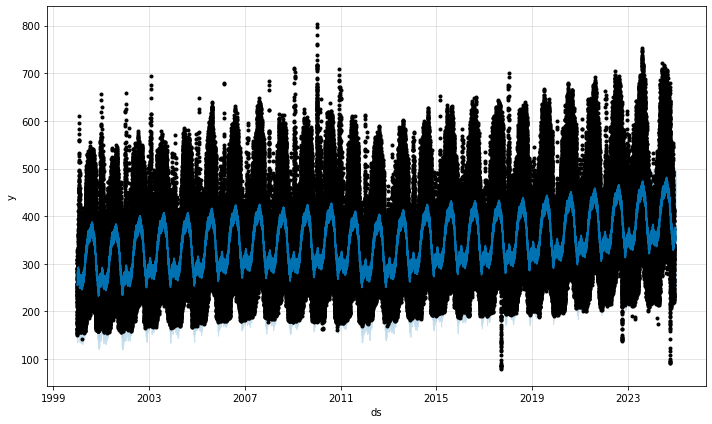

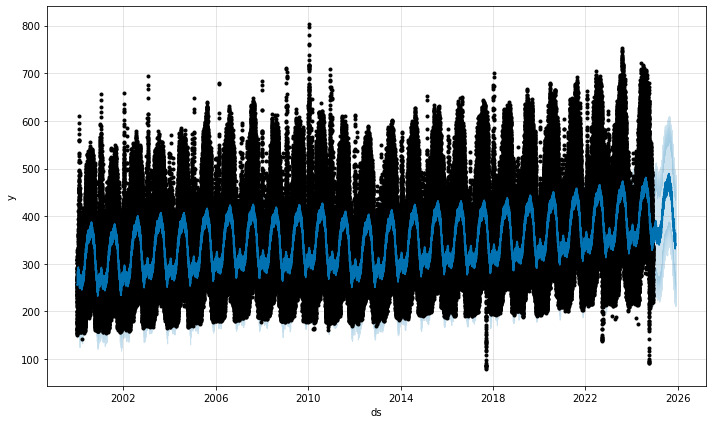

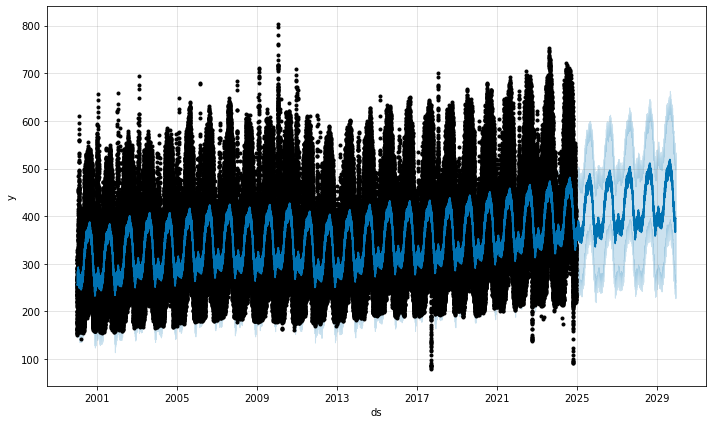

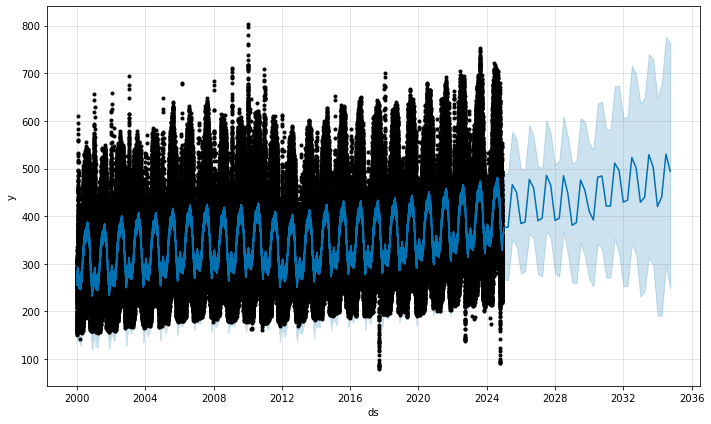

In [11]:
import pandas as pd
import numpy as np
from prophet import Prophet
import os

# Create output directory if not exists
output_dir = "prophet_files"
os.makedirs(output_dir, exist_ok=True)

# Load the merged dataset
merged_data = pd.read_csv(f"{output_dir}/merged_load_weather_data.csv")

# Convert date column to datetime
merged_data["Dt"] = pd.to_datetime(merged_data["Dt"])

# Prepare data for Prophet
prophet_df = merged_data.rename(columns={"Dt": "ds", "BasicLoad": "y"})[["ds", "y"]]

# Initialize and fit the basic Prophet model
model = Prophet()
model.fit(prophet_df)

# Define forecast periods
forecasts = {
    "30d": model.make_future_dataframe(periods=24*30, freq='H'),  # 30-day hourly
    "1y": model.make_future_dataframe(periods=24*365, freq='H'),  # 1-year hourly
    "5y": model.make_future_dataframe(periods=365*5, freq='D'),  # 5-year daily
    "10y": model.make_future_dataframe(periods=4*10, freq='Q')  # 10-year quarterly
}

# Generate and save forecasts
for name, future_df in forecasts.items():
    forecast = model.predict(future_df)
    forecast.to_csv(f"{output_dir}/no_regressors_load_forecast_{name}.csv", index=False)
    model.plot(forecast).savefig(f"{output_dir}/no_regressors_load_forecast_{name}.png")

print("All forecasts completed and saved.")


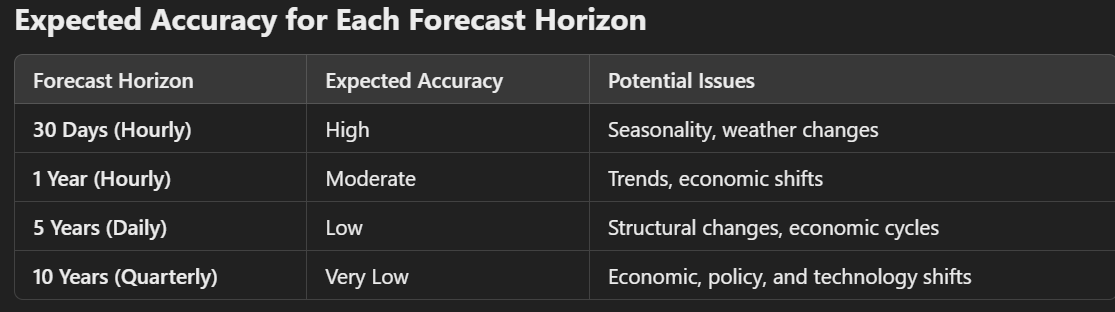

option 1 - use values for moodey for every hour/day in the quarter
option 2 - interpolate value as the 'center' and create a way to scale it to the next 'center' from the next quarter

moodey's: get the actual data and compare how they work